In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.metrics import r2_score

In [3]:
df_clean = pd.read_csv("Dataset/clean_df.csv")
df_clean.head()

,Unnamed: 0,id_tracks,name_tracks,popularity_tracks,explicit,danceability,energy,key,loudness,mode,...,followers,genres,name_artists,popularity_artists,year,month,day,dayofweek,weekofyear,duration_ms_log
0,56,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,0,0.434,0.1770,1,-21.180,1,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,21,1,12,12.109782
1,57,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,0,0.321,0.0946,7,-27.961,1,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,21,1,12,12.083379
2,58,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,0,0.548,0.0391,6,-23.228,1,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,29,2,13,12.107208
3,59,0l3BQsVJ7F76wlN5QhJzaP,El Vendaval - Remasterizado,0,0,0.370,0.3720,2,-17.138,1,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,21,1,12,11.941671
4,60,0xJCJ9XSNcdTIz0QKmhtEn,La Maleva - Remasterizado,0,0,0.339,0.0958,8,-26.944,1,...,3528.0,"tango', 'vintage tango",Ignacio Corsini,23,1922,3,29,2,13,12.108680


In [4]:
df_clean.sort_values(by = ["year","month","day"], inplace = True)
df_clean.drop_duplicates(subset = ["name_tracks","name_artists"], keep = 'last', inplace=True, ignore_index=True)

# Based on the distribution of track popularity, I suspect many cases with popularity 0 are missing value. By looking up
# some cases on Spotify, I think my suspecion might be true.

#df_clean = df_clean[df_clean.popularity_tracks!=0]

In [5]:
# Map id and name of artists to a single numerical id
unique_artists = df_clean[['name_artists', 'id_artists']].drop_duplicates()
artist_ids, unique_values = pd.factorize(unique_artists['id_artists'])
unique_artists['artist_num_id'] = artist_ids
df_clean = pd.merge(df_clean, unique_artists[['name_artists', 'artist_num_id']], 
                    on='name_artists', how='left')

# Drop unused columns 
dropped_columns = ['Unnamed: 0','id_tracks','name_tracks','id_artists','name_artists']
df_clean = df_clean.drop(columns=dropped_columns)

In [6]:
# Transform the string of genres to a tuple
def genre_transform (genre_string):
  genre_list = genre_string.split(", ")
  genre_list = [s.strip("'") for s in genre_list]
  return tuple(genre_list)

df_clean['genres'] = df_clean['genres'].apply(genre_transform)

# Print the number of genres
all_genres = np.unique(np.concatenate(df_clean["genres"].values))
print("There are "+str(len(all_genres))+" different genres in the dataset.")

# Do a target encoding on each tuple of genres
encoder = TargetEncoder(cols=["genres"])
df_target = df_clean['popularity_tracks']
encoder.fit(df_clean, df_target)
df_clean = encoder.transform(df_clean)

There are 4407 different genres in the dataset.


C:\Users\XMhua\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\XMhua\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [7]:
#bins = [-1, 10, 20, 30, 40, 50, 60, 100]
#group_name = [i for i in range(0,7)]
#df_clean['popularity_score'] = pd.cut(df_clean.popularity_tracks, bins = bins, labels = group_name)
#df_clean.drop(axis=1, labels = "popularity_tracks", inplace = True)

In [8]:
pd.set_option('display.max_columns', None)
df_clean.head()

,popularity_tracks,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,popularity_artists,year,month,day,dayofweek,weekofyear,duration_ms_log,artist_num_id
0,19,0,0.659,0.791,2,-4.895,1,0.0295,0.139,0.000002,0.1610,0.9560,141.999,4,21048.0,30.765217,49,1900,1,1,0,1,12.362734,0
1,0,0,0.402,0.158,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,11327.0,5.279070,35,1921,1,1,6,52,12.001996,1
2,0,0,0.227,0.261,5,-12.343,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4,11327.0,5.279070,35,1921,1,1,6,52,12.094767,1
3,0,0,0.347,0.197,10,-15.652,1,0.0504,0.991,0.000133,0.1960,0.2460,109.338,3,11327.0,5.279070,35,1921,1,1,6,52,12.163233,1
4,0,0,0.269,0.255,0,-9.041,1,0.0536,0.984,0.002630,0.1780,0.1540,79.186,4,11327.0,5.279070,35,1921,1,1,6,52,12.107357,1


In [9]:
num_features = ['duration_ms_log', 'explicit', 'danceability', 'energy', 'key',
                'loudness', 'mode', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo',
                'time_signature', 'followers', 'popularity_artists', 'year',
               'month', 'day', 'dayofweek', 'weekofyear', 'artist_num_id', 
                'genres']
target = ['popularity_tracks']

Highly correlated pairs = []


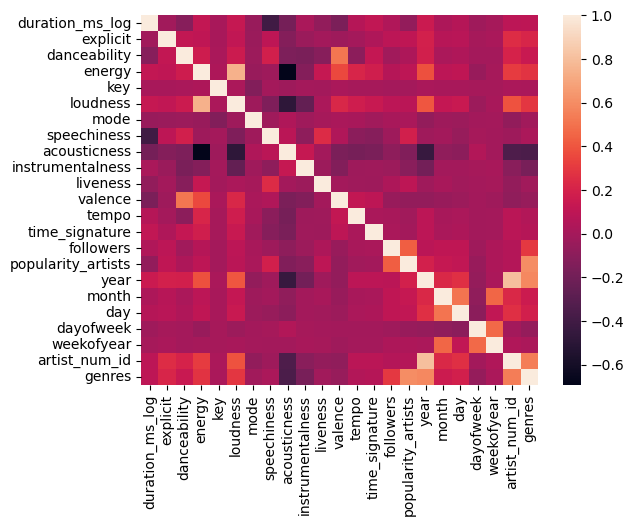

In [10]:
df_X = df_clean[num_features]
corr = df_X.corr()
sns.heatmap(corr)

#Find the pairs of features correlated above 0.9
corr_column_names = corr.columns
highly_correlated_pairs = []

for i in range (0,len(corr_column_names)):
    corr_column_name = corr_column_names[i]
    corr_column_values = corr[corr_column_name].values
    for j in range (i,len(corr_column_values)):
        if (i!=j) and (abs(corr_column_values[j]) >= 0.9):
            highly_correlated_pairs.append((corr_column_names[i],corr_column_names[j]))

print("Highly correlated pairs = "+str(highly_correlated_pairs))
#df_X = df_X.drop(labels='genres', axis = 1)

In [11]:
df_X.shape

(388578, 23)

In [12]:
#num_classes = 7
#y = keras.utils.to_categorical(np.array(df_clean[target]).reshape(-1), num_classes)
y = np.array(df_clean[target]).reshape(-1)
x = df_X
x_dev, x_test, y_dev, y_test = train_test_split(x,y, test_size = 0.2)

In [13]:
# Standardize dataset x
scaler = StandardScaler()
x_dev_st = scaler.fit_transform(x_dev)
x_test_st = scaler.transform(x_test)


In [14]:
# split development set into train and validation sets

x_train, x_val, y_train, y_val = train_test_split(x_dev_st, y_dev,
                                                 test_size = 0.2
                                                 )

Build a neural network

Hidden layer size - 15

Second layer size - 7

In [15]:
model = keras.Sequential([
    keras.Input(shape=(df_X.shape[1],)),
    keras.layers.Dense(150, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation = 'linear')
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               3600      
                                                                 
 dense_1 (Dense)             (None, 10)                1510      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [17]:

model.compile(optimizer= "adam", loss=keras.losses.MeanSquaredError())
history = model.fit(x_train, y_train, batch_size= 64, epochs=20, verbose=1,
 validation_data = (x_val, y_val))

Epoch 1/20
3886/3886 [==============================] - 4s 899us/step - loss: 112.3869 - val_loss: 89.1624
Epoch 2/20
3886/3886 [==============================] - 3s 870us/step - loss: 88.6144 - val_loss: 86.9916
Epoch 3/20
3886/3886 [==============================] - 3s 860us/step - loss: 87.2806 - val_loss: 85.8237
Epoch 4/20
3886/3886 [==============================] - 3s 856us/step - loss: 86.0922 - val_loss: 85.5732
Epoch 5/20
3886/3886 [==============================] - 3s 859us/step - loss: 85.2776 - val_loss: 84.4852
Epoch 6/20
3886/3886 [==============================] - 3s 868us/step - loss: 84.6362 - val_loss: 84.9141
Epoch 7/20
3886/3886 [==============================] - 3s 877us/step - loss: 84.0753 - val_loss: 83.8260
Epoch 8/20
3886/3886 [==============================] - 3s 882us/step - loss: 83.6959 - val_loss: 83.4238
Epoch 9/20
3886/3886 [==============================] - 3s 883us/step - loss: 83.3878 - val_loss: 83.3164
Epoch 10/20
3886/3886 [======================

In [18]:
y_pred = model.predict(x_test_st)
score = r2_score(y_test, y_pred)
print("r2 score on test data:", score)

2429/2429 [==============================] - 1s 555us/step
r2 score on test data: 0.7049786217110507


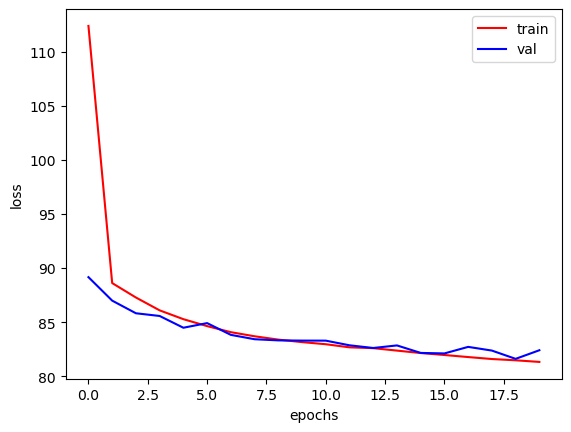

In [19]:
# display train vs validation loss over each epoch
hist = pd.DataFrame(history.history)
plt.plot(hist.index, hist["loss"], 'r')
plt.plot(hist.index, hist["val_loss"], 'b')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(['train','val'])

In [20]:
# Finally, let's train the model using development dataset

model_dev = keras.Sequential([
    keras.Input(shape=(df_X.shape[1],)),
    keras.layers.Dense(150, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation = 'relu')
])
model_dev.compile(optimizer= "adam", loss=keras.losses.MeanSquaredError())
history = model_dev.fit(x_dev_st, y_dev, batch_size= 64, epochs=20, verbose=1)

Epoch 1/20
4858/4858 [==============================] - 4s 751us/step - loss: 111.2055
Epoch 2/20
4858/4858 [==============================] - 4s 758us/step - loss: 87.4017
Epoch 3/20
4858/4858 [==============================] - 4s 740us/step - loss: 85.7202
Epoch 4/20
4858/4858 [==============================] - 4s 748us/step - loss: 84.6654
Epoch 5/20
4858/4858 [==============================] - 4s 727us/step - loss: 83.9854
Epoch 6/20
4858/4858 [==============================] - 4s 758us/step - loss: 83.4398
Epoch 7/20
4858/4858 [==============================] - 4s 762us/step - loss: 82.9969
Epoch 8/20
4858/4858 [==============================] - 4s 740us/step - loss: 82.6482
Epoch 9/20
4858/4858 [==============================] - 4s 743us/step - loss: 82.3413
Epoch 10/20
4858/4858 [==============================] - 4s 737us/step - loss: 82.0485
Epoch 11/20
4858/4858 [==============================] - 4s 743us/step - loss: 81.8243
Epoch 12/20
4858/4858 [============================

In [21]:
y_pred2 = model_dev.predict(x_test_st)
score = r2_score(y_test, y_pred2)
print("r2 score on test data:", score)

2429/2429 [==============================] - 1s 560us/step
r2 score on test data: 0.7099904894781208


In [22]:
# serialize model to JSON
model_json = model_dev.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_dev.save_weights("model/model.h5")
print("Saved model to disk")


Saved model to disk
